In [11]:
import datetime
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

num_classes = 2
model = AlexNet((227, 227, 3), num_classes)

In [2]:
IMG_SIZE = 32

In [66]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()


In [67]:
# resize images for vgg19
import cv2

def resize(img_array):
    tmp = np.empty((img_array.shape[0], IMG_SIZE, IMG_SIZE))

    for i in range(len(img_array)):
        img = img_array[i].reshape(28, 28).astype('uint8')
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32')/255
        tmp[i] = img
        
    return tmp

train_x_resize = resize(x_train)
test_x_resize = resize(x_test)
print(train_x_resize.shape)
print(test_x_resize.shape)

(60000, 32, 32)
(10000, 32, 32)


In [68]:
train_x_final = np.stack((train_x_resize,)*3, axis=-1)
test_x_final = np.stack((test_x_resize,)*3, axis=-1)
print(train_x_final.shape)
print(test_x_final.shape)

(60000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
# Another way to do so:
# x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
# x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
# x_train = tf.expand_dims(x_train, axis=3, name=None)
# x_test = tf.expand_dims(x_test, axis=3, name=None)
# x_train = tf.repeat(x_train, 3, axis=3)
# x_test = tf.repeat(x_test, 3, axis=3)
# x_val = x_train[-2000:,:,:,:]
# y_val = y_train[-2000:]
# x_train = x_train[:-2000,:,:,:]
# y_train = y_train[:-2000]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(train_x_final, y_train, test_size=0.2, random_state=10)

In [71]:
model = models.Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Resizing(224, 224, 
                                                              interpolation="bilinear", 
                                                              input_shape=X_train.shape[1:]))

model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))

model.add(layers.Conv2D(256, 5, strides=4, padding='same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))

model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(256, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_6 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 96)        34944     
_________________________________________________________________
lambda_2 (Lambda)            (None, 56, 56, 96)        0         
_________________________________________________________________
activation_5 (Activation)    (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 256)         614656    
_________________________________________________________________
lambda_3 (Lambda)            (None, 7, 7, 256)        

In [72]:
model.compile(optimizer='adam', 
              loss=losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])


In [73]:
earl = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

In [75]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=64, 
                    epochs=20, 
                    validation_data=(X_test, y_test),
                    callbacks=[earl])


Epoch 1/20
750/750 [==============================] - 83s 109ms/step - loss: 0.6910 - accuracy: 0.7489 - val_loss: 0.1317 - val_accuracy: 0.9640
Epoch 2/20
750/750 [==============================] - 82s 109ms/step - loss: 0.0996 - accuracy: 0.9727 - val_loss: 0.0775 - val_accuracy: 0.9793
Epoch 3/20
750/750 [==============================] - 83s 111ms/step - loss: 0.0783 - accuracy: 0.9796 - val_loss: 0.0785 - val_accuracy: 0.9791
Epoch 4/20
750/750 [==============================] - 84s 112ms/step - loss: 0.0580 - accuracy: 0.9849 - val_loss: 0.0927 - val_accuracy: 0.9793
Epoch 5/20
750/750 [==============================] - 84s 112ms/step - loss: 0.0498 - accuracy: 0.9874 - val_loss: 0.0828 - val_accuracy: 0.9794
Epoch 00005: early stopping


In [87]:
model.save_weights('weights/alexnet_weights')

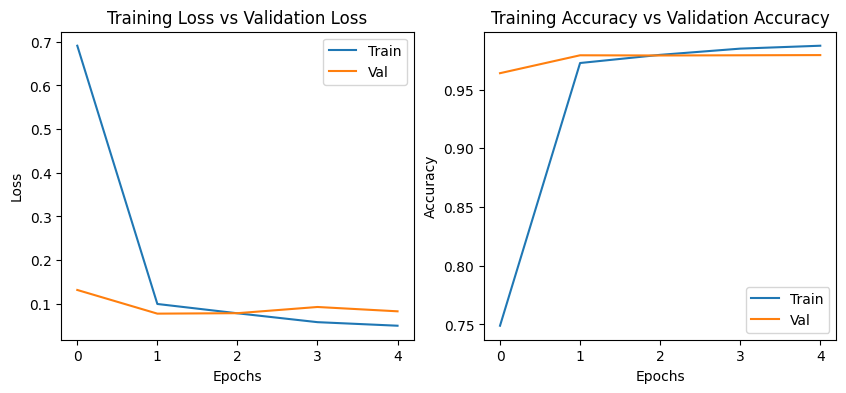

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])